In [47]:
from importlib import reload

import modeltuning_LUNA; reload(modeltuning_LUNA)
from modeltuning_LUNA import *

import utils_LUNA; reload(utils_LUNA)
from utils_LUNA import *

In [48]:
luna_path = "../input/LUNA16/"
luna_subset_path = "../input/LUNA16/subset0/"
output_path = "../input/LUNA16/output/"
model_path = "../input/LUNA16/models/"
working_path = output_path
if not os.path.exists(model_path): os.makedirs(model_path)

### Loading and preprocessing train data

In [49]:
imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

In [50]:
imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)

In [51]:
imgs_train.shape, imgs_mask_train.shape, imgs_test.shape, imgs_mask_test_true.shape

((268, 512, 512, 1), (268, 512, 512, 1), (66, 512, 512, 1), (66, 512, 512, 1))

image 6


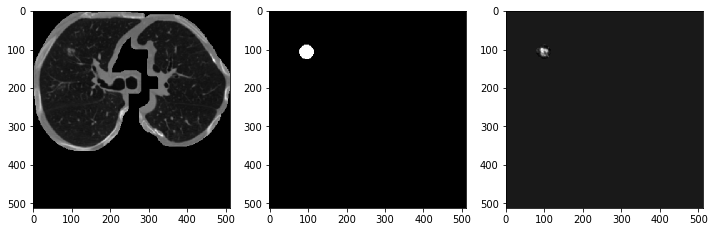

In [54]:
i = 6
print("image %d" % i)
fig,ax = plt.subplots(1,3,figsize=[12,12])
ax[0].imshow(np.squeeze(imgs_train[i]),cmap='gray')
ax[1].imshow(np.squeeze(imgs_mask_train[i]),cmap='gray')
ax[2].imshow(np.squeeze(imgs_train[i])*np.squeeze(imgs_mask_train[i]),cmap='gray')
plt.show()

In [55]:
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std

### Creating and compiling model

In [56]:
model = get_unet()

In [57]:
# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint(model_path+'unet.hdf5', monitor='loss', save_best_only=True)

### Fitting model

In [58]:
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=4, verbose=2, shuffle=True,
              callbacks=[model_checkpoint])

Epoch 1/4
 28/268 [==>...........................] - ETA: 6057s - loss: -1.9016e-05 - dice_coef: 1.9016e-0 - ETA: 4846s - loss: -4.0773e-05 - dice_coef: 4.0773e-0 - ETA: 5861s - loss: -3.3687e-05 - dice_coef: 3.3687e-0 - ETA: 5349s - loss: -5.0132e-05 - dice_coef: 5.0132e-0 - ETA: 5676s - loss: -5.1562e-05 - dice_coef: 5.1562e-0 - ETA: 5367s - loss: -4.7812e-05 - dice_coef: 4.7812e-0 - ETA: 5601s - loss: -4.2978e-05 - dice_coef: 4.2978e-0 - ETA: 5364s - loss: -3.9240e-05 - dice_coef: 3.9240e-0 - ETA: 5096s - loss: -3.8926e-05 - dice_coef: 3.8926e-0 - ETA: 5310s - loss: -3.7226e-05 - dice_coef: 3.7226e-0 - ETA: 5088s - loss: -3.6453e-05 - dice_coef: 3.6453e-0 - ETA: 5197s - loss: -3.7030e-05 - dice_coef: 3.7030e-0 - ETA: 5038s - loss: -3.6836e-05 - dice_coef: 3.6836e-0 - ETA: 4883s - loss: -3.8394e-05 - dice_coef: 3.8394e-05

KeyboardInterrupt: 

### Load best weights from training session

In [ ]:
model.load_weights(model_path+'unet.hdf5')

### Predicting masks on test data

In [ ]:
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,512,512,1],dtype=np.float32) # Channels Last
#imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0) #[0] # Channels Last
np.save('masksTestPredicted.npy', imgs_mask_test)
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(np.squeeze(imgs_mask_test_true[i]), np.squeeze(imgs_mask_test[i]))
mean/=num_test
print("Mean Dice Coeff : ",mean)